In [1]:
import pandas as pd
#from sklearn.preprocessing import Imputer
#from sklearn.impute import SimpleImputer
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from stldecompose import decompose
import time
from functools import reduce
from functools import partial
import tensorflow as tf
from datetime import datetime
import random
from random import randrange
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from datetime import timedelta
from random import shuffle
from scipy import sparse
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, LSTM, Dropout
from tensorflow.python.keras.optimizers import RMSprop , Adam, SGD
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import TimeDistributed, Activation, RepeatVector, BatchNormalization
ip=get_ipython()
user_ns=ip.user_ns
import_ls=%who_ls

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1547619337901833484
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 20309735506
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9663408719013220358
physical_device_desc: "device: 0, name: Quadro RTX 6000, pci bus id: 0000:2d:00.0, compute capability: 7.5"
]


In [133]:
import nvidia_smi

nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

res = nvidia_smi.nvmlDeviceGetUtilizationRates(handle)
print(f'gpu: {res.gpu}%, gpu-mem: {res.memory}%')

gpu: 20%, gpu-mem: 1%


In [3]:
import requests

def lookup(s):
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

url = 'https://www.alphavantage.co/query'
s = requests.Session()
s.proxies = {"https": "https://fdyinetbc2:80"}
params = dict(
    function='TIME_SERIES_DAILY',
    symbol='SPX',
    outputsize='full',
    datatype='json',
    apikey='QM6G54H15VWV99R1'
)

resp = s.get(url=url, params=params)
data = resp.json()
df=pd.DataFrame.from_dict(data['Time Series (Daily)']).T
df=df.reset_index()
df.columns=['DateTime','Open','High','Low','Close','Volume']
df['DateTime']=lookup(df['DateTime'])

ProxyError: HTTPSConnectionPool(host='www.alphavantage.co', port=443): Max retries exceeded with url: /query?function=TIME_SERIES_DAILY&symbol=SPX&outputsize=full&datatype=json&apikey=QM6G54H15VWV99R1 (Caused by ProxyError('Cannot connect to proxy.', OSError('Tunnel connection failed: 407 Proxy Authentication Required')))

In [7]:
df

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2019-11-18,3117.9099,3124.1699,3112.0601,3120.7200,3120.7200,1190366810,0.0,1.0
1,2019-11-15,3107.9199,3120.4600,3104.6001,3120.4600,3120.4600,3335650000,0.0,1.0
2,2019-11-14,3090.7500,3098.2000,3083.2600,3096.6299,3096.6299,3276070000,0.0,1.0
3,2019-11-13,3084.1799,3098.0601,3078.8000,3094.0400,3094.0400,3509280000,0.0,1.0
4,2019-11-12,3089.2800,3102.6101,3084.7300,3091.8401,3091.8401,3466010000,0.0,1.0
...,...,...,...,...,...,...,...,...,...
4997,2000-01-07,1403.4500,1441.4700,1400.7300,1441.4700,1441.4700,1225200000,0.0,1.0
4998,2000-01-06,1402.1100,1411.9000,1392.1000,1403.4500,1403.4500,1092300000,0.0,1.0
4999,2000-01-05,1399.4200,1413.2700,1377.6801,1402.1100,1402.1100,1085500000,0.0,1.0
5000,2000-01-04,1455.2200,1455.2200,1397.4301,1399.4200,1399.4200,1009000000,0.0,1.0


In [11]:
def lookup(s):
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)
df=pd.read_csv('daily_adjusted_SPX.csv')
df.columns=['DateTime','Open','High','Low','Close','Adjusted_Close','Volume','Dividend_Amount','Split_Coefficient']
df['DateTime']=lookup(df['DateTime'])
df=df[['DateTime','Open','High','Low','Close','Volume']]

In [13]:
#create base time range
time_range=df[['DateTime']].set_index('DateTime').copy()

datetime_base=pd.date_range(start=time_range.index.min(),
              end=time_range.index.max(),
              freq='1D')
datetime_base=pd.DataFrame(datetime_base,columns=['DateTime'])
df=pd.merge(datetime_base,df,on=['DateTime'],how='left')

In [14]:
df['Hour'] = df['DateTime'].dt.hour
df['Weekday'] = df['DateTime'].dt.weekday
df['Monthday'] =df['DateTime'].dt.day
cal = calendar()
#df_new=df_new.sort_values(['StoreNumber','DateTime']).reset_index()
holidays=cal.holidays(df.DateTime.min(), end=df.DateTime.max())
holidays=[i.date() for i in holidays]
df.loc[df['DateTime'].dt.date.isin(holidays),'Holidays']=2

holidays=cal.holidays(df.DateTime.min(), end=df.DateTime.max())- timedelta(days=1)
holidays=[i.date() for i in holidays]
df.loc[df['DateTime'].dt.date.isin(holidays),'Holidays']=1

holidays=cal.holidays(df.DateTime.min(), end=df.DateTime.max())+ timedelta(days=1)
holidays=[i.date() for i in holidays]
df.loc[df['DateTime'].dt.date.isin(holidays),'Holidays']=3
df.loc[df['Holidays'].isnull(),'Holidays']=0

In [15]:
var_ls=%who_ls
set(var_ls)-set(import_ls)

{'cal',
 'datetime_base',
 'df',
 'holidays',
 'import_ls',
 'lookup',
 'params',
 'requests',
 's',
 'time_range',
 'url'}

In [16]:
del cal,holidays,var_ls,datetime_base,time_range

In [17]:
df.columns

Index(['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Hour', 'Weekday',
       'Monthday', 'Holidays'],
      dtype='object')

In [18]:
df['Holidays']=df['Holidays'].astype(int)
df['Open']=df['Open'].transform('ffill')
df['High']=df['High'].transform('ffill')
df['Low']=df['Low'].transform('ffill')
df['Close']=df['Close'].transform('ffill')
df['Volume']=df['Volume'].fillna(0)

In [3]:
#df_new.to_pickle('df_new_model_ready')
#df_new=pd.read_pickle('df_new_model_ready')

In [19]:
cat_columns=['Hour','Weekday','Monthday', 'Holidays', ]
target_names=['Open']
prev_columns=list(df.columns)
prev_columns.remove('DateTime')
unknowns=[]
#knowns=list(set(df_new.columns)-set(target_names+unknowns))
shift_days = 1
shift_steps = shift_days * 1  # Number of hours.

#df_targets = df_new.groupby('StoreNumber')[target_names].shift(-shift_steps).dropna().copy()
#x_data_present=df_new[knowns][shift_steps:].copy()

df_present=df.transform(lambda x: x.shift(-shift_steps)).dropna().copy()
df_present.reset_index(drop=True, inplace=True)
#x_data_df[['Hour']]=x_data_df[['Hour']].apply(lambda x: np.sin(2.0*np.pi*(x+0.5)/24.0)+np.cos(2.0*np.pi*(x+0.5)/24.0))
#x_data_df[['Weekday']]=x_data_df[['Weekday']].apply(lambda x: np.sin(2.0*np.pi*(x-0.5)/7.0)+np.cos(2.0*np.pi*(x-0.5)/7.0))
#x_data_df=pd.get_dummies(x_data_df, columns=['Hour', 'Weekday'])
df_previous=df[prev_columns].transform(lambda x: x.shift(shift_steps)).dropna().copy()
df_previous.reset_index(drop=True, inplace=True)
df_previous.columns=[s + '_prev' for s in df_previous.columns]

df=pd.concat([df_present,df_previous],axis=1)

In [11]:
#df.to_pickle('df_model_ready')
#df=pd.read_pickle('df_model_ready')

In [21]:
var_ls=%who_ls
set(var_ls)-set(import_ls)

{'cat_columns',
 'df',
 'df_present',
 'df_previous',
 'import_ls',
 'lookup',
 'params',
 'prev_columns',
 'requests',
 's',
 'shift_days',
 'shift_steps',
 'target_names',
 'unknowns',
 'url'}

In [22]:
del df_present,df_previous,var_ls

In [23]:
df=pd.get_dummies(df,columns=cat_columns)

In [24]:
target_names=['Open','High','Low','Close',]
num_data = len(df)
x_cols=list(set(df.columns)-set(['DateTime'])-set(target_names))
val_cols=[ 'Open_prev',
 'High_prev',
 'Low_prev',
 'Close_prev',]
x_scaled=df[x_cols].copy()
y_scaled=df[['DateTime']+target_names].copy()
x_scaler= MinMaxScaler()
x_scaled[val_cols]=x_scaler.fit_transform(x_scaled[val_cols])
y_scaler= MinMaxScaler()
y_scaled[target_names]=y_scaler.fit_transform(y_scaled[target_names])
#np.save('x_train_scaled.npy',x_train_scaled)
#np.save('y_train_scaled.npy',y_train_scaled)
#np.save('x_test_scaled.npy',x_test_scaled)
#np.save('y_test_scaled.npy',y_test_scaled)

In [25]:
train_split = 0.85
datetime_length=df.DateTime.drop_duplicates().count()
num_train = int(train_split * datetime_length)
num_test = datetime_length - num_train
x_train = x_scaled[:num_train]
x_test = x_scaled[num_train:]
y_train = y_scaled[:num_train]
y_test = y_scaled[num_train:]
#num_x_signals = x_data.shape[1]
#num_y_signals = y_data.shape[1]

In [54]:
y_train

,DateTime,Open,High,Low,Close
0,2000-01-04,0.318187,0.312878,0.298797,0.295759
1,2000-01-05,0.295305,0.295607,0.290720,0.296859
2,2000-01-06,0.296408,0.295043,0.296618,0.297407
3,2000-01-07,0.296958,0.307217,0.300147,0.312963
4,2000-01-08,0.296958,0.307217,0.300147,0.312963
...,...,...,...,...,...
6165,2016-11-20,0.618204,0.615348,0.618987,0.615897
6166,2016-11-21,0.618031,0.618976,0.621461,0.622558
6167,2016-11-22,0.624236,0.621487,0.624765,0.624505
6168,2016-11-23,0.623001,0.621454,0.624765,0.625234


In [26]:
arr_x_train=sparse.csr_matrix(x_train.values.astype(float))
arr_y_train=y_train.values
arr_x_test=sparse.csr_matrix(x_test.values.astype(float))
arr_y_test=y_test.values
#sparse.save_npz('arr_x_train.npz', arr_x_train)
#np.save('arr_y_train.npy',arr_y_train, allow_pickle=True)
#sparse.save_npz('arr_x_test.npz', arr_x_test)
#np.save('arr_y_test.npy',arr_y_test, allow_pickle=True)

In [3]:
#arr_x_train = sparse.load_npz('arr_x_train.npz')
#arr_y_train = np.load('arr_y_train.npy', allow_pickle=True)
#arr_x_test = sparse.load_npz('arr_x_test.npz')
#arr_y_test = np.load('arr_y_test.npy', allow_pickle=True)

In [27]:
num_x_signals = arr_x_train.shape[1]
num_y_signals = arr_y_train.shape[1]-1
num_test=arr_y_test.shape[0]
x_shape= (1, num_test, num_x_signals)
x_val = np.zeros(shape=x_shape, dtype=np.float16)
y_shape= (1, num_test, num_y_signals)
y_val = np.zeros(shape=y_shape, dtype=np.float16)
i=0
x_val[0] = arr_x_test[:,:].toarray()
y_val[0] = arr_y_test[:,1:]
validation_data = (x_val,y_val)

In [37]:
n_epochs=40
#sequence_length = 24 * 7 * 3
sequence_length=90
stride=1
datetime_train_length=arr_y_train.shape[0]
batch_size=20#125
batch_max=math.ceil((datetime_train_length-sequence_length)/stride+1)
n_batchs=math.ceil(batch_max/batch_size)
batch_length=sequence_length+stride*(batch_size-1)

def fill_rands(n):
    rand_ls = list(range(n))
    shuffle(rand_ls)
    return rand_ls

def make_rand_vars():
    if batch_max<batch_size: return print('batch size is greater than max batch size')
    rand_vars=np.zeros((n_batchs*n_epochs,1), dtype=np.int32)
    rand_ls=[]
    for i in range(n_batchs*n_epochs):
        if rand_ls==[]:
            rand_ls=fill_rands(n_batchs)
        n_batch = random.choice(rand_ls)
        rand_ls.remove(n_batch)
        rand_vars[i]=[n_batch]
    return rand_vars
rand_vars=make_rand_vars()

In [55]:
def storedata_generator2(sequence_length, batch_size, stride=24):
    """
    Generator function for creating random batches of training-data.
    """
    # infinite loop.
    store_random_ls=[]
    
    # Allocate a new array for the batch of input-signals.
    x_shape = (batch_size, sequence_length, num_x_signals)
    x_batch = np.zeros(shape=x_shape, dtype=np.float16)

    # Allocate a new array for the batch of output-signals.
    y_shape = (batch_size, sequence_length, num_y_signals)
    y_batch = np.zeros(shape=y_shape, dtype=np.float16)
    x_store=arr_x_train.toarray()
    y_store=arr_y_train[:,1:]
    s=0
    while True:
        n_batch=rand_vars[s][0]

        for i in range(batch_size):
            if (n_batch != n_batchs-1)&(n_batchs != 1):
                start = (n_batch*batch_size+i)*stride
            elif (n_batchs == 1):
                if i != batch_size-1:
                    start = i*stride
                else:
                    start =  datetime_train_length-sequence_length                    
            else:
                start = datetime_train_length - batch_length + stride*i
            end = start + sequence_length        
            x_batch[i] = x_store[start:end]
            y_batch[i] = y_store[start:end]
        s+=1
        yield (x_batch, y_batch)

In [58]:
%%time
generator = storedata_generator2(sequence_length,batch_size,stride)
x_batch, y_batch = next(generator)

Wall time: 2.85 ms


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1285483471202375484
]


In [22]:
%timeit -n 10 x_batch, y_batch = next(generator)

225 µs ± 70.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
generator = storedata_generator2(sequence_length,batch_size,
                           stride)
#generator = TimeseriesGenerator(x_train_scaled, y_train_scaled, length=3, batch_size=2,sampling_rate=4)
#x_batch, y_batch = next(generator)
#batch = 0   # First sequence in the batch.
#signal = 0  # First signal from the 20 input-signals.


In [24]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [46]:
#model1
model = Sequential()
#model.add(GRU(units=512,
model.add(LSTM(units=512,
              #dropout=0.0, recurrent_dropout=0.0,
              #kernel_initializer=keras.initializers.RandomNormal(seed=1337),
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
#model.add(Dropout(0.4))
model.add(LSTM(256, dropout=0.0
               ,return_sequences=True,
               #kernel_initializer=keras.initializers.RandomNormal(seed=1337),
              ))
model.add(LSTM(128, dropout=0.0
               ,return_sequences=True
               #kernel_initializer=keras.initializers.RandomNormal(seed=1337),
              ))
model.add(Dense(num_y_signals, activation='sigmoid'))
"""
if False:
    from tensorflow.python.keras.initializers import RandomUniform
    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))
"""
warmup_steps = 50
#optimizer = RMSprop(lr=1e-3)
optimizer = Adam(lr=1e-3)
#model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.compile(loss=tf.losses.mean_squared_error, optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 512)         1159168   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 256)         787456    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         197120    
_________________________________________________________________
dense (Dense)                (None, None, 4)           516       
Total params: 2,144,260
Trainable params: 2,144,260
Non-trainable params: 0
_________________________________________________________________


In [47]:
path_checkpoint = 'checkpoint_test_future.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=2,
                                       verbose=1)
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [48]:
%%time
#model 4
#load best!
history = model.fit_generator(generator=generator,
                    epochs=n_epochs,
                    verbose=1,
                    shuffle=False,
                    steps_per_epoch=n_batchs,
                    validation_data=validation_data,
                    callbacks=callbacks)
#score, acc = model.evaluate(validation_data)
#print('Test score:', score)
#print('Test accuracy:', acc)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Epoch 1/40


ValueError: Tried to convert 'y' to a tensor and failed. Error: None values not supported.

In [ ]:
%%time
#model 4
#load best!
history = model.fit_generator(generator=generator,
                    epochs=n_epochs,
                    verbose=1,
                    shuffle=False,
                    steps_per_epoch=n_batch_steps,
                    validation_data=validation_data,
                    callbacks=callbacks)
#score, acc = model.evaluate(validation_data)
#print('Test score:', score)
#print('Test accuracy:', acc)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Epoch 1/40
 567/1096 [==============>...............] - ETA: 1:52:04 - loss: 0.0097

In [16]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [17]:
result = model.evaluate(x=x_val,
                        y=y_val)

1096/1096 [==============================] - 35s 32ms/sample - loss: 0.0083


In [26]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        pripred,x,y_turent("{0}: {1:.3e}".format(metric, res))

In [123]:
x_test[x_test.StoreNumber==store].values[:,1:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [124]:
DateTime=np.array(df['DateTime'].drop_duplicates())
def plot_comparison_store(store, start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x=arr_x_train[arr_x_train[:,0]==store,1:]
        time_range=DateTime[:num_train ]
        y_true = arr_y_train[arr_y_train[:,0]==store,1:]
    else:
        # Use test-data.
        x = x_test[x_test.StoreNumber==store].values[:,1:]
        time_range=DateTime[num_train: ]
        y_true = y_test[y_test.StoreNumber==store].values[:,1:]
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    time_range=time_range[start_idx:end_idx]
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    print(y_pred[0].shape)
    y_pred_rescaled = y_scaler[store].inverse_transform(y_pred[0])
    #y_pred_rescaled = y_pred[0]
    y_true=y_scaler[store].inverse_transform(y_true)
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(time_range,signal_true, label='true')
        plt.plot(time_range,signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(time_range[0], time_range[warmup_steps], facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

In [114]:
store_ls

[1001,
 1005,
 1009,
 1015,
 1016,
 1018,
 1020,
 1025,
 1028,
 1033,
 1035,
 1041,
 1047,
 1061,
 1070,
 1076,
 1083,
 1086,
 1090,
 1099,
 1129,
 1131,
 1134,
 1137,
 1140,
 1143,
 1146,
 1153,
 1154,
 1156,
 1157,
 1158,
 1159,
 1163,
 1170,
 1172,
 1174,
 1180,
 1182,
 1183,
 1189,
 1190,
 1191,
 1193,
 1194,
 1195,
 1197,
 1199,
 1200,
 1201,
 1203,
 1204,
 1205,
 1206,
 1207,
 1213,
 1215,
 1216,
 1217,
 1218,
 1219,
 1220,
 1230,
 1231,
 1232,
 1251,
 1260,
 1261,
 1262,
 1264,
 1300,
 1302,
 1305,
 1308,
 1310,
 1311,
 1319,
 1321,
 1323,
 1325,
 1327,
 1331,
 1401,
 1402,
 1403,
 1404,
 1405,
 1412,
 1413,
 1414,
 1415,
 1416,
 1417,
 1418,
 1419,
 1420,
 1421,
 1422,
 1423,
 1424,
 1425,
 1426,
 1427,
 1428,
 1429,
 1430,
 1432,
 1433,
 1502,
 1505,
 1507,
 1547,
 1804,
 1810,
 1829,
 1848,
 2034,
 2080,
 2089,
 2090,
 2120,
 2121,
 2205,
 2206,
 2209,
 2210,
 2211,
 2213,
 2214,
 2215,
 2221,
 2222,
 2223,
 2225,
 2227,
 2229,
 2230,
 2231,
 2233,
 2236,
 2240,
 2242,
 2243,

(760, 1)


c:\users\md38\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


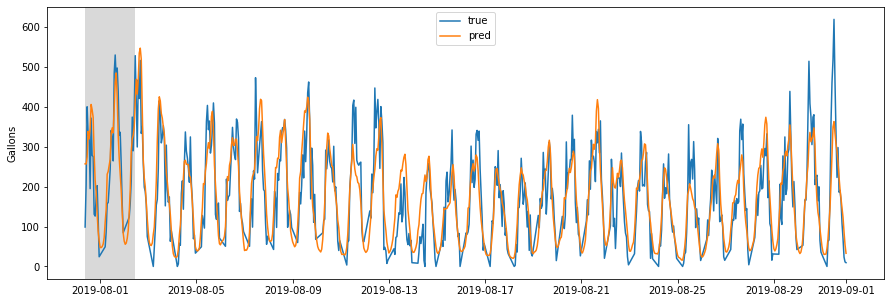

In [125]:
#current
plot_comparison_store(6308, 0, length=930, train=False)

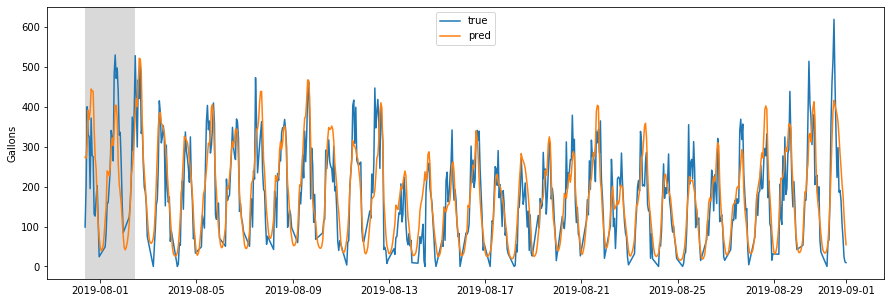

In [120]:
#old
plot_comparison_store(6308, 0, length=930, train=False)

(760, 1)


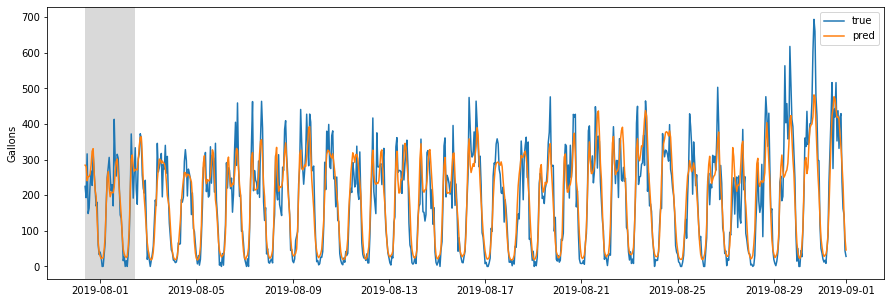

In [126]:
# current
plot_comparison_store(8527, 0, length=930, train=False)

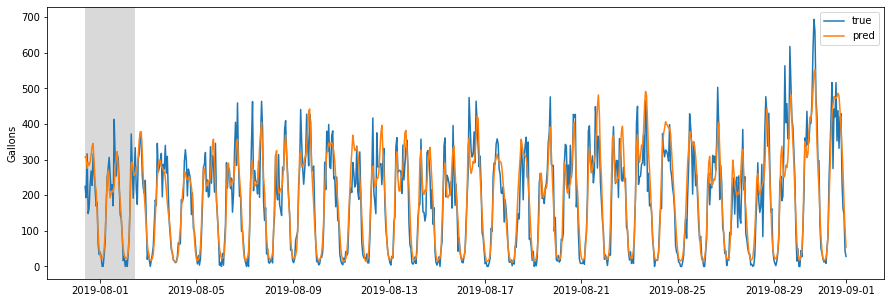

In [119]:
# old
plot_comparison_store(8527, 0, length=930, train=False)

In [ ]:
X=[['Hour','Weekday','Monthday','City', 
               'State', 'Holidays', 'Population','StoreScale',
                'Restore_ind','Cost', 'Price', 'Margin',   
                 ]]
y=['Gallons']

(760, 1)


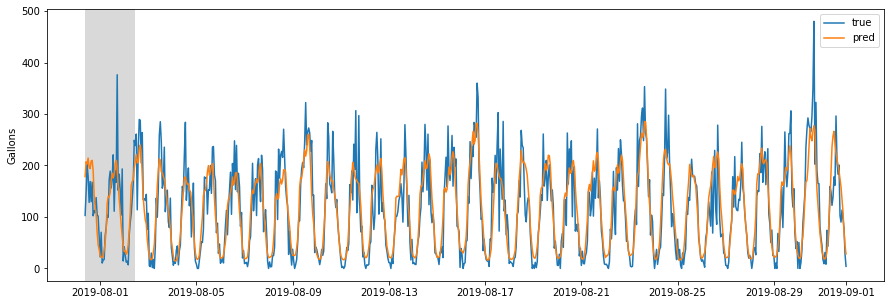

In [127]:
#current
plot_comparison_store(8036, 0, length=930, train=False)

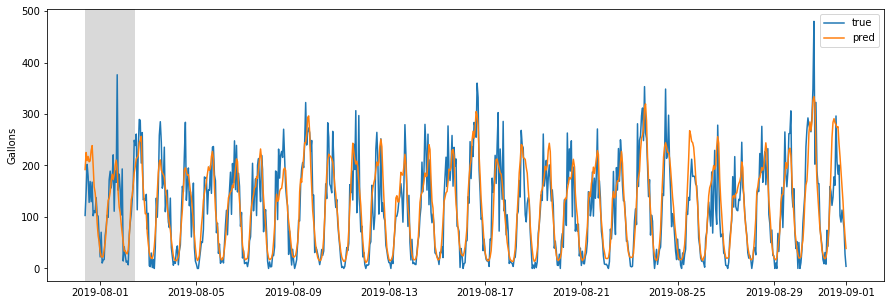

In [118]:
#old
plot_comparison_store(8036, 0, length=930, train=False)

(760, 1)


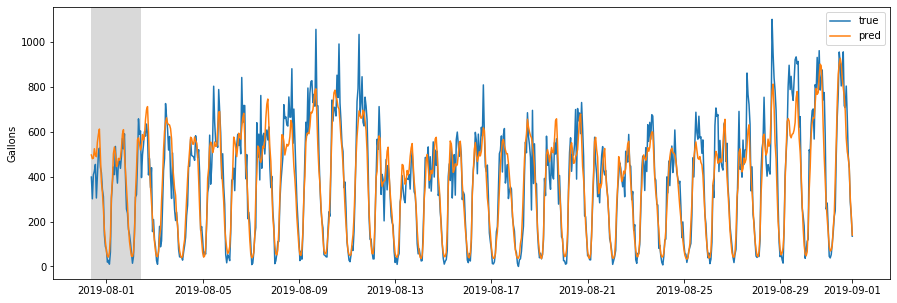

In [128]:
# current
plot_comparison_store(2346, 0, length=930, train=False)

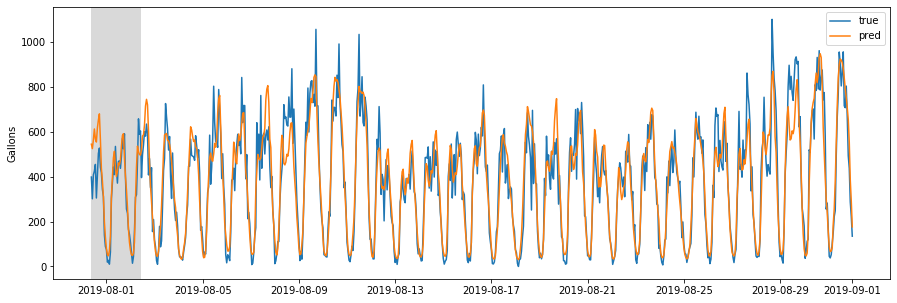

In [115]:
# old
plot_comparison_store(2346, 0, length=930, train=False)

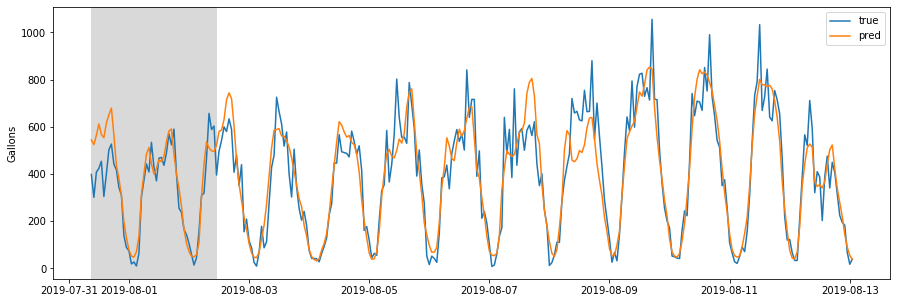

In [129]:
#old
plot_comparison_store(2346, 0, length=305, train=False)

(760, 1)


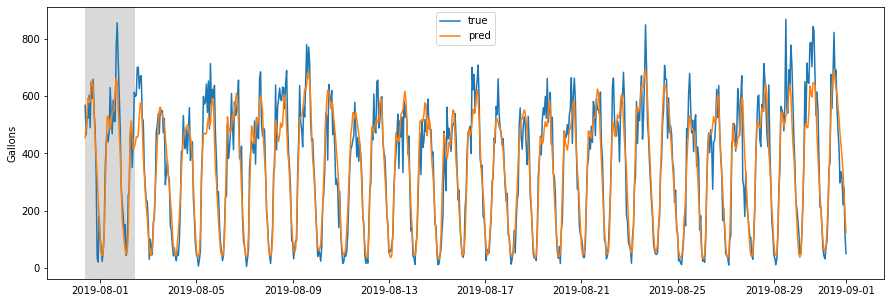

In [129]:
#current
plot_comparison_store(3698, 0, length=930, train=False)

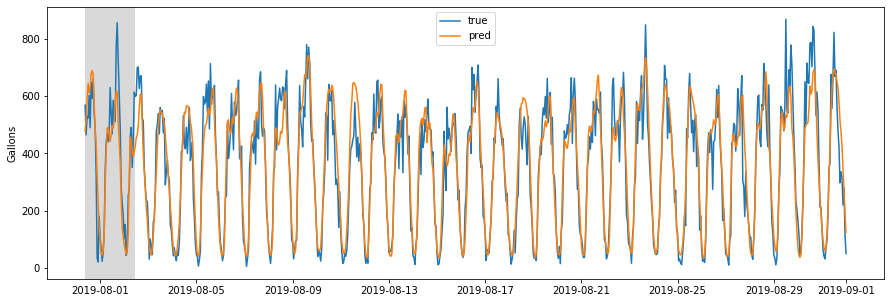

In [116]:
#old
plot_comparison_store(3698, 0, length=930, train=False)

(930, 1)


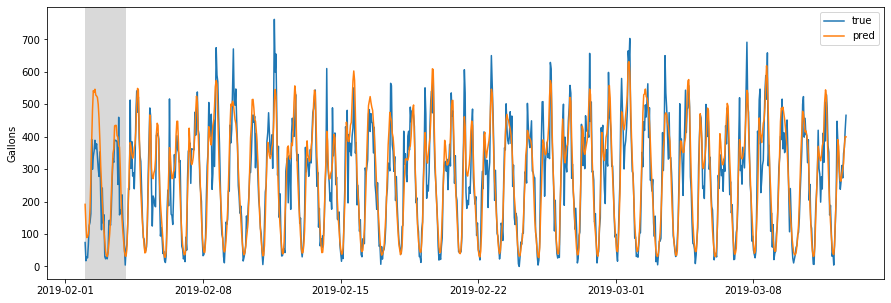

In [130]:
# batch_size=450 (new columns) 3 layers 19 epochs
#Epoch 20/20 200/200 [==============================] - 271s 1s/step - loss: 5.8716e-06 - val_loss: 4.1859e-04

plot_comparison_store(7519, 0, length=930, train=True)